In [2]:
from matplotlib import pyplot as plt
import cv2 as cv
import numpy as np
import os
from natsort import natsorted


def plot_image(img, figsize_in_inches=(5,5)):
    fig, ax = plt.subplots(figsize=figsize_in_inches)
    ax.imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))
    plt.show()
    
def plot_images(imgs, figsize_in_inches=(5,5)):
    fig, axs = plt.subplots(1, len(imgs), figsize=figsize_in_inches)
    for col, img in enumerate(imgs):
        axs[col].imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))
    plt.show()


In [13]:
# Path to the folder containing the images
folder_path = "D:/Tests/Column_test/"

# Read in the images from the folder and sort them using natsort
files = natsorted(os.listdir(folder_path))
images_path = [(os.path.join(folder_path, file )) for file in files]

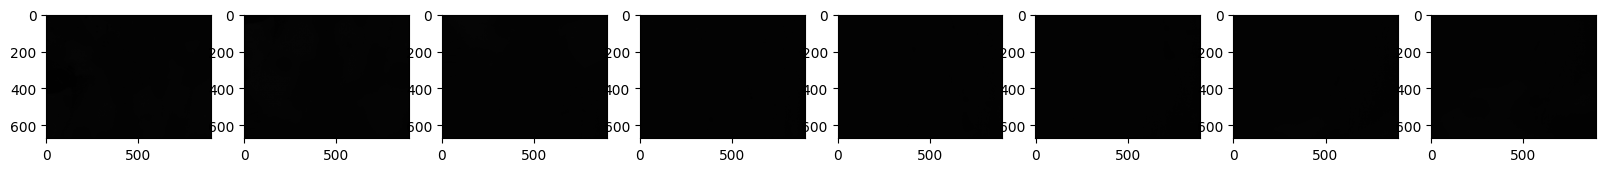

Original Size: (4056, 3040)  -> 12,330,240 px ~ 1 MP
Medium Size:   (895, 671)  -> 600,545 px ~ 0.6 MP
Low Size:      (365, 274)   -> 100,010 px ~ 0.1 MP
Final Size:    (4056, 3040)  -> 12,330,240 px ~ 1 MP


In [14]:
from stitching.images import Images

images = Images.of(images_path)

medium_imgs = list(images.resize(Images.Resolution.MEDIUM))
low_imgs = list(images.resize(Images.Resolution.LOW))
final_imgs = list(images.resize(Images.Resolution.FINAL))

plot_images(medium_imgs, (20,20))

original_size = images.sizes[0]
medium_size = images.get_image_size(medium_imgs[0])
low_size = images.get_image_size(low_imgs[0])
final_size = images.get_image_size(final_imgs[0])

print(f"Original Size: {original_size}  -> {'{:,}'.format(np.prod(original_size))} px ~ 1 MP")
print(f"Medium Size:   {medium_size}  -> {'{:,}'.format(np.prod(medium_size))} px ~ 0.6 MP")
print(f"Low Size:      {low_size}   -> {'{:,}'.format(np.prod(low_size))} px ~ 0.1 MP")
print(f"Final Size:    {final_size}  -> {'{:,}'.format(np.prod(final_size))} px ~ 1 MP")

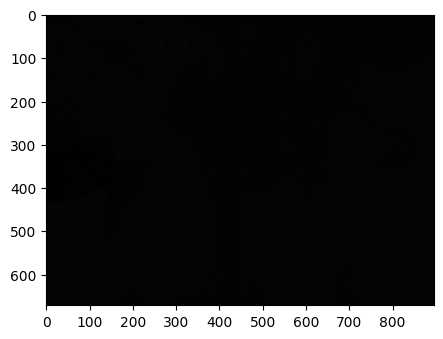

In [15]:
from stitching.feature_detector import FeatureDetector

finder = FeatureDetector(detector ="sift",  nfeatures=500)
features = [finder.detect_features(img) for img in medium_imgs]
keypoints_center_img = finder.draw_keypoints(medium_imgs[0], features[0])


plot_image(keypoints_center_img, (5,5))

In [16]:
from stitching.feature_matcher import FeatureMatcher

matcher = FeatureMatcher(matcher_type='BFmatcher', range_width=-1, match_conf=0.1)
matches = matcher.match_features(features)

In [17]:
matcher.get_confidence_matrix(matches)


array([[0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.]])

Matches Image 1 to Image 2


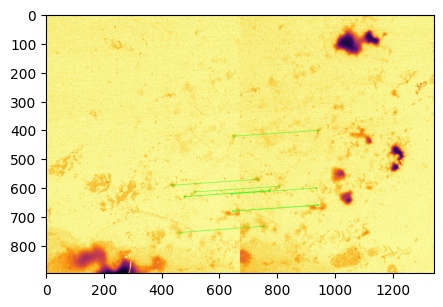

Matches Image 1 to Image 6


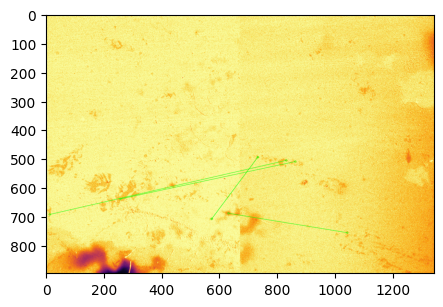

Matches Image 2 to Image 3


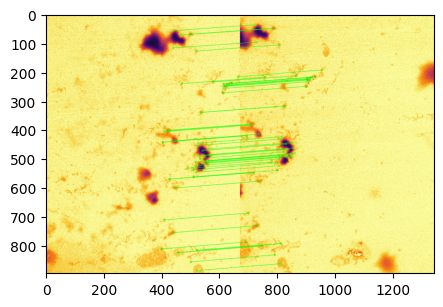

Matches Image 2 to Image 4


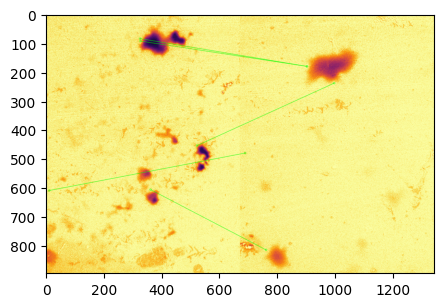

Matches Image 3 to Image 4


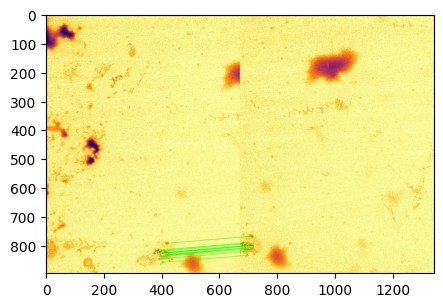

Matches Image 3 to Image 6


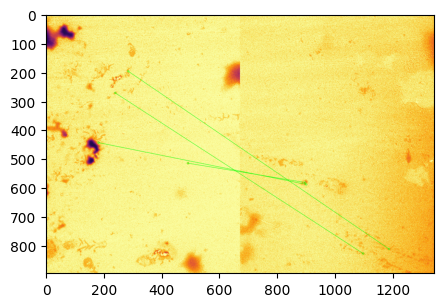

Matches Image 3 to Image 8


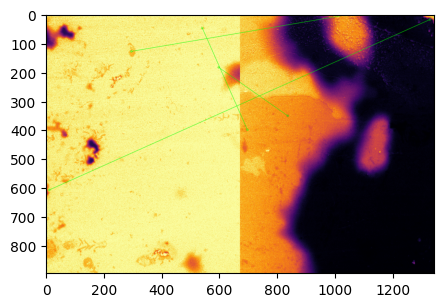

Matches Image 7 to Image 8


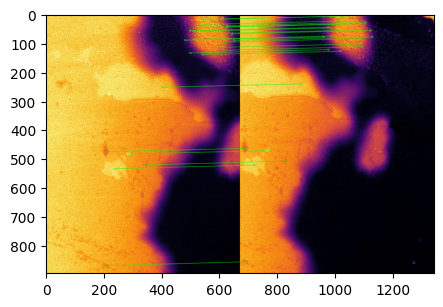

In [139]:
all_relevant_matches = matcher.draw_matches_matrix(medium_imgs, features, matches, conf_thresh=0.4, 
                                                   inliers=True, matchColor=(0, 255, 0))

for idx1, idx2, img in all_relevant_matches:
    print(f"Matches Image {idx1+1} to Image {idx2+1}")
    plot_image(img, (5,5))

In [125]:
from stitching.subsetter import Subsetter

subsetter = Subsetter(confidence_threshold=0.4)
dot_notation = subsetter.get_matches_graph(images.names, matches)
print(dot_notation)

graph matches_graph{
"calibrated_image_0.tiff" -- "calibrated_image_1.tiff"[label="Nm=24, Ni=11, C=0.723684"];
"calibrated_image_1.tiff" -- "calibrated_image_2.tiff"[label="Nm=77, Ni=58, C=1.86495"];
"calibrated_image_2.tiff" -- "calibrated_image_3.tiff"[label="Nm=31, Ni=19, C=1.09827"];
"calibrated_image_3.tiff" -- "calibrated_image_4.tiff"[label="Nm=12, Ni=6, C=0.517241"];
"calibrated_image_4.tiff" -- "calibrated_image_5.tiff"[label="Nm=6, Ni=5, C=0.510204"];
"calibrated_image_4.tiff" -- "calibrated_image_6.tiff"[label="Nm=6, Ni=4, C=0.408163"];
"calibrated_image_6.tiff" -- "calibrated_image_7.tiff"[label="Nm=31, Ni=21, C=1.21387"];
}


In [126]:
indices = subsetter.get_indices_to_keep(features, matches)

medium_imgs = subsetter.subset_list(medium_imgs, indices)
low_imgs = subsetter.subset_list(low_imgs, indices)
final_imgs = subsetter.subset_list(final_imgs, indices)
features = subsetter.subset_list(features, indices)
matches = subsetter.subset_matches(matches, indices)

images.subset(indices)

print(images.names)
print(matcher.get_confidence_matrix(matches))

['D:/Tests/Column_test3/Images_Calibrated/calibrated_image_0.tiff', 'D:/Tests/Column_test3/Images_Calibrated/calibrated_image_1.tiff', 'D:/Tests/Column_test3/Images_Calibrated/calibrated_image_2.tiff', 'D:/Tests/Column_test3/Images_Calibrated/calibrated_image_3.tiff', 'D:/Tests/Column_test3/Images_Calibrated/calibrated_image_4.tiff', 'D:/Tests/Column_test3/Images_Calibrated/calibrated_image_5.tiff', 'D:/Tests/Column_test3/Images_Calibrated/calibrated_image_6.tiff', 'D:/Tests/Column_test3/Images_Calibrated/calibrated_image_7.tiff']
[[0.         0.72368421 0.3960396  0.37383178 0.         0.38461538
  0.         0.        ]
 [0.72368421 0.         1.86495177 0.3539823  0.3539823  0.
  0.         0.        ]
 [0.3960396  1.86495177 0.         1.0982659  0.38461538 0.
  0.         0.        ]
 [0.37383178 0.3539823  1.0982659  0.         0.51724138 0.
  0.         0.38461538]
 [0.         0.3539823  0.38461538 0.51724138 0.         0.51020408
  0.40816327 0.        ]
 [0.38461538 0.       

In [ ]:
CameraEstimator(estimator='homography')
CameraAdjuster(adjuster='ray', refinement_mask='xxxxx')
WaveCorrector(wave_correct_kind='horiz')

In [127]:
from stitching.camera_estimator import CameraEstimator
from stitching.camera_adjuster import CameraAdjuster
from stitching.camera_wave_corrector import WaveCorrector

camera_estimator = CameraEstimator(estimator='affine')
camera_adjuster = CameraAdjuster(adjuster='affine', refinement_mask='xxxxx')
wave_corrector = WaveCorrector(wave_correct_kind='no')

cameras = camera_estimator.estimate(features, matches)
cameras = camera_adjuster.adjust(features, matches, cameras)
cameras = wave_corrector.correct(cameras)

In [128]:
from stitching.warper import Warper

warper = Warper(warper_type= 'affine')
warper.set_scale(cameras)

low_sizes = images.get_scaled_img_sizes(Images.Resolution.LOW)
camera_aspect = images.get_ratio(Images.Resolution.MEDIUM, Images.Resolution.LOW)  # since cameras were obtained on medium imgs

warped_low_imgs = list(warper.warp_images(low_imgs, cameras, camera_aspect))
warped_low_masks = list(warper.create_and_warp_masks(low_sizes, cameras, camera_aspect))
low_corners, low_sizes = warper.warp_rois(low_sizes, cameras, camera_aspect)



In [129]:
final_sizes = images.get_scaled_img_sizes(Images.Resolution.FINAL)
camera_aspect = images.get_ratio(Images.Resolution.MEDIUM, Images.Resolution.FINAL)

warped_final_imgs = list(warper.warp_images(final_imgs, cameras, camera_aspect))
warped_final_masks = list(warper.create_and_warp_masks(final_sizes, cameras, camera_aspect))
final_corners, final_sizes = warper.warp_rois(final_sizes, cameras, camera_aspect)

error: OpenCV(4.7.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\imgwarp.cpp:1724: error: (-215:Assertion failed) dst.cols < SHRT_MAX && dst.rows < SHRT_MAX && src.cols < SHRT_MAX && src.rows < SHRT_MAX in function 'cv::remap'


KeyboardInterrupt: 

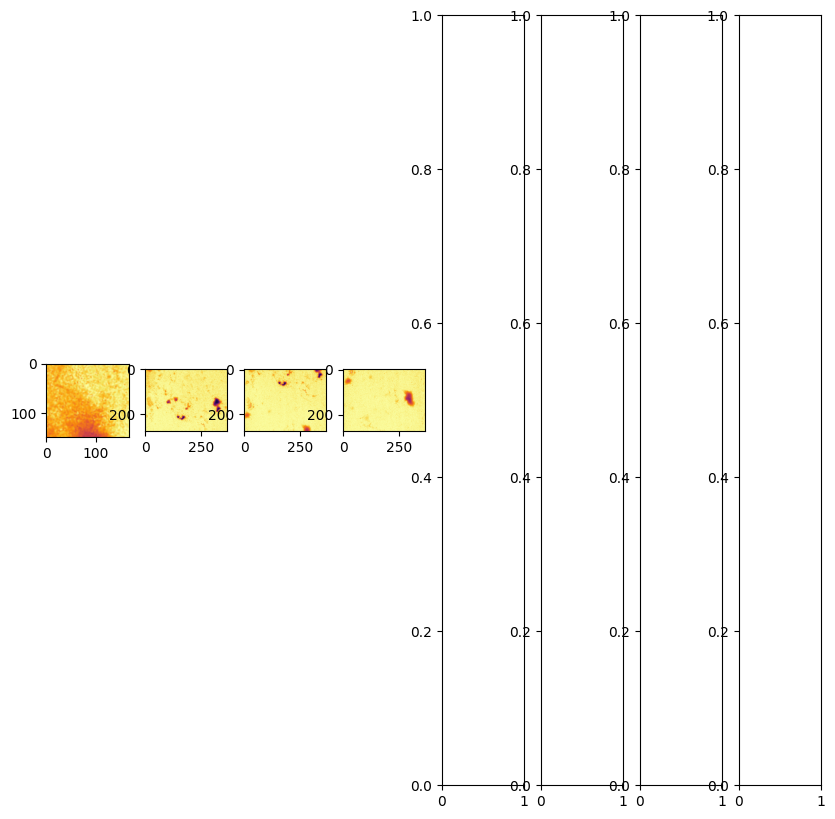

In [130]:
plot_images(warped_low_imgs, (10,10))
plot_images(warped_low_masks, (10,10))